# StackOverflow Analysis

Popular question and answer (qna) site - stackoverflow (& their sister sites - http://stackexchange.com/sites) witnesses tremendous activity daily where netizens post questions, recieve answers, comments and engage in an active discussion. 

We want to analyze this data with the intention to identify __related__ questions. In general, the analysis presented in this notebook can be used in a variety of scenarios. Some illustrative examples include

* Power users use multiple browser tabs simultaneously. Using the techniques outlined below, we can identify and group similar tabs together. With the appropriate visual cues, similar tabs can be identified at a glance.

* Many products provide a twitter handle to offer support. User questions about the product or service related queries (all within the twitter 140 char limit) can be grouped based on similarity.

The Stack Exchange network uploads monthly dumps of their data which we have used for analysis.

> "The anonymized dump of all user-contributed content on the Stack Exchange network. Each site is formatted as a separate archive consisting of XML files zipped via 7-zip using bzip2 compression. Each site archive includes Posts, Users, Votes, Comments, PostHistory and PostLinks. For complete schema information, see the included readme.txt.

> All user content contributed to the Stack Exchange network is cc-by-sa 3.0 licensed, intended to be shared and remixed. We even provide all our data as a convenient data dump."

** From : https://archive.org/details/stackexchange **


## Schema & Data Munging

The schema for their data is located @ https://ia800500.us.archive.org/22/items/stackexchange/readme.txt.
    
However,

* All the data is dumped in XML format. So we need to write a converter to convert the XML data into a tabular format.
* Since the size of data is huge, we need to load data in a streaming fashion. 
* All the exchange sites share identical schema!


The first step is to then write a converter which does this. Our [Streaming XML2CSV Converter](convertp2csv.py) expects input data to be present at [input/english](input/english) for english.stackexchange.com, [input/aviation](input/aviation) for aviation.stackexchange.com etc. Similarly, the converted data is dumped at [output/english](output/english) and [output/aviation](output/aviation) respectively.

Also, note the converter outputs the csv file in a zipped format as pandas (the lib we use to read data) understands zip formats natively.

Please download the data from https://archive.org/download/stackexchange/english.stackexchange.com.7z and https://archive.org/download/stackexchange/aviation.stackexchange.com.7z into the input folders to run the dashboard. Alternatively, a sample run output has been stored in the respective output folders.


In [7]:
#imports
import warnings
warnings.filterwarnings('ignore')

import os
import os.path

import pandas as pd
import numpy as np
import math
import re
import gensim
from gensim import corpora, models,similarities
from gensim.models import Doc2Vec, TfidfModel
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pprint import pprint                        # pretty-printer

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

SAMPLE_SIZE = 200000

SITE1 = 'english' #.stackexchange.com
SITE2 = 'aviation' #.stackexchange.com

## 0. Convert Data from XML to CSV

In [4]:
from convertso2csv import process

process(os.getcwd() + '/input')

skipping aviation...
skipping english...


# Data loading

For the purposes of this analysis, we use only post title and body. However, we will show the other data also made available to us from stackexchange. This can be used to further enrich the analysis. But this is not done in the current notebook.

### Note :

The original data is large. So to play around with the data, we have provide some knobs to tune within the notebooks (versus putting them in the parser)

1. ** SAMPLE_SIZE **  (#default value as 20k records)
2. ** SITE1 ** (#default value is english)
3. ** SITE2 ** (#default value is aviation)

Feel free to change this value to experiment or get better results.

### 1. Load the aviation stackexchange data.

In [2]:
path = 'output/'+SITE2+'/'+'posts.csv.gz'
posts_aviation = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
posts_aviation['Tags'] = posts_aviation['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))

posts_aviation[['Body','Title', 'Tags']].head(2)

,Body,Title,Tags
0,i recently had the opportunity to fly a par ap...,what does it mean when the controller uses the...,air-traffic-control radio-communications ph...
4,i ve never had the opportunity to fly into a c...,should you wait to switch to the ground freque...,air-traffic-control runways


### 2. Load the english stackexchange data.

In [3]:
path = 'output/'+SITE1+'/'+'posts.csv.gz'
posts_english = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
posts_english['Tags'] = posts_english['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))

posts_english[['Body','Title', 'Tags']].head(2)

,Body,Title,Tags
0,when should i use can when should i use could...,when do i use can or could,word-choice tenses politeness subjunctive-...
1,doesn t quint mean five what does that h...,where does the quint in quintessential com...,etymology


Related data can also be loaded. However, for the purposes of this demonstration, we are not exploiting the data from the tables below.

In [63]:
path = 'output/'+SITE2+'/'+'comments.csv.gz'
comments = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna()
comments[['Score','Text']].head(5)

,Score,Text
0,0,right of course i use request all the time ...
1,1,the few times i ve spoken to military controll...
2,5,congrats on the first question on aviation
3,1,garrisonneely thanks i love the platform b...
4,1,in the u s i think the controllers would typ...


In [64]:
path='output/'+SITE1+'/'+'posthistory.csv.gz'
posthistory = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Text'])
posthistory[['Text']].head(5)

,Text
0,when could i use can or when can i use could ...
1,when do i could can could
3,doesn t quint mean five what does that hav...
4,where does the quint in quintessential come ...
6,which is the correct use of these two words an...


In [65]:
path='output/' + SITE1 + '/' + 'users.csv.gz'
users = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['AboutMe','Location'])
users[['Location','AboutMe']].head(5)

,Location,AboutMe
0,on the server farm,hi i m not really a person i m a background ...
1,corvallis or,developer on the stack overflow team find me...
2,new york ny,developer on the stack overflow team was dubb...
3,raleigh nc,i design stuff for stack exchange also a prof...
4,california,i slip my front end into the back end and the...


### Note

The relationship between all these tables and the detailed meaning of all the attributes and values can be found @
https://ia800500.us.archive.org/22/items/stackexchange/readme.txt
    

## Data cleansing - Stop Words & Word Stems

Once the data is loaded, we want to remove all the stop words present in the raw data. The ** stop_words ** instance can be used for the remainder of the program to achieve this.

In [4]:
class StopWords():
    def __init__(self):
        self.stop_words = stopwords.words('english')
        self.stop_words.append('use')

    def remove(self, sentence):
        return [tok for tok in sentence.split() if not tok in self.stop_words and len(tok) > 1]
    

In [5]:
class SentenceTokens():
    def __init__(self,df,field):
        self.field = field
        self.df = df
    
    def __iter__(self):
        for index, row in self.df.iterrows():
            raw_sentence = row[self.field]
            yield stop_words.remove(raw_sentence)

In [6]:
def get_dictionary(force=False):
    dictFile = 'models/posts.dict'

    # Check if trained model file exists
    if ( os.path.isfile(dictFile) and not force):
        dictionary = corpora.Dictionary.load(dictFile)
    else:
        #How frequently each term occurs within each document? We construct a document-term matrix.
        dictionary = corpora.Dictionary(allposts)
        dictionary.filter_extremes(no_below=5, no_above=10)
        # store the dictionary, for future reference
        dictionary.save(dictFile) 

    return dictionary

# Bag of words
# corpus is a list of vectors equal to the number of documents. 
# In each document vector is a series of tuples. 
def get_corpus(force=False):
    corpusFile = 'models/posts.mm'
    
    # Check if corpus file is found
    if ( os.path.isfile(corpusFile) and not force ):
        corpus = corpora.MmCorpus(corpusFile)
    else:
        # Create corpus
        corpus = [dictionary.doc2bow(post) for post in allposts]
        
        # Store corpus to file
        corpora.MmCorpus.serialize(corpusFile, corpus) #Save the bow corpus
        
    return corpus

In [7]:
# Create stop words object
stop_words = StopWords() 

# analyze across sites. Control frames to 1..M site analysis
frames = [posts_aviation, posts_english]
frames = [posts_english]
posts = pd.concat(frames)

#all posts is a list of (list of tokens). The inner list of tokens is created once for each post
allposts = SentenceTokens(posts,'Title')
forceload = True #Set this to false to avoid computation. Loads the corpus and dictionary from disk.

dictionary = get_dictionary(force=forceload)
corpus = get_corpus(force=forceload)
#print(len(corpus))
#print(len(dictionary))

## 1. Find out the number of topics
===========================================

We were not aware of the number of topic, so we decided to reduce the number of features to two dimensions, then clustering the points for different values of K (number of clusters) to find an optimum value. 

One such transform is the Latent Semantic Indexing (LSI) transform, which we use to project the original data to 2D.

In [76]:
def get_lsi_model(force = False):
    lsimodelFile = 'models/lsi.model'
    
    # Check if corpus file is found
    if ( os.path.isfile(lsimodelFile) and not force):
        lsimodel = models.LsiModel.load(lsimodelFile)
    else:
        # Create model
        # num_topics: required. An LDA model requires the user to determine how many topics should be generated. 
        # id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
        tfidf = TfidfModel(corpus, normalize=True)
        corpus_tfidf = tfidf[corpus]
        lsimodel = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
        
        # save model to disk (no need to use pickle module)
        lsimodel.save(lsimodelFile)

    return lsimodel   

In [77]:
# Get LSI Model
lsi = get_lsi_model(force=True)

We clustered the points in the this reduced space using KMeans, varying the number of clusters (K) from 1 to 10. 
We used the Inertia of the cluster provided by Scikit-Learn KMeans algorithm. 

** Ref ** : http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means


## From the above analysis, we will use number of clusters as 5

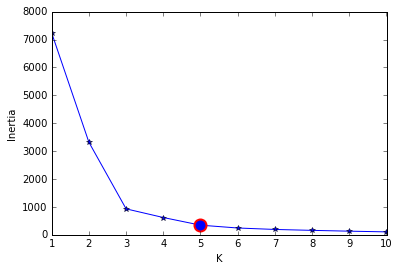

In [78]:

D = ''
for vector in lsi[corpus]:
    if 2 == len(vector):
        #'1 2; 3 4' => 2 X 2
        D = D + `round(vector[0][1],4)` + ' ' + `round(vector[1][1],4)` + ';'
        
X = np.matrix(D[:-1])


MAX_K = 10
ks = range(1, MAX_K + 1)

inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

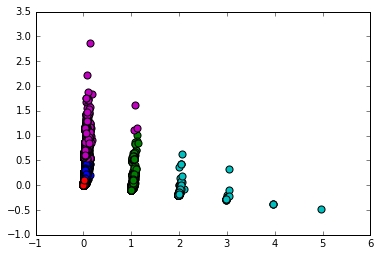

In [79]:
NUM_TOPICS = 5

kmeans = KMeans(NUM_TOPICS).fit(X)
y = kmeans.labels_

colors = ["b", "g", "r", "m", "c", "p", "y"] #Not expecting more than 5 for the data size
for i in range(X.shape[0]):
    plt.scatter(X[i,0] ,X[i,1], c=colors[y[i]], s=50)    

plt.show()

## For the aviation site, the cluster spread looks like 


<img src='images/aviation.png'>

## 2. Sample Search Demonstration
=============================================

In this section, we take a sample question, remove the stop words, and search using the LSI Model just created. We visually inspect the output for correctness.

In [48]:
def QSim(document): # Query function for document
    # Apply stop words
    doc_processed = stop_words.remove(document)
    # create vector
    vec_bow = dictionary.doc2bow(doc_processed)
    # convert the query (sample vector) to LSI space
    vec_lsi = lsi[vec_bow]
    # find indexes of similar sims
    index = similarities.MatrixSimilarity(lsi[corpus]) 
    # perform a similarity query against the corpus
    sims = index[vec_lsi]
    return sims

In [49]:
# Find similar questions by converting it into vector
samples = ['Where does the quint in quintessential come from?',
           'Where does goodness me come from?']

In [50]:
# Search for similar documents
sims = QSim(samples[0])

# Sort in descending order - highest matching percentage on top
sorted_sims = sorted(enumerate(sims), key=lambda item: -item[1])
sims_list = list(enumerate(sorted_sims))

In [106]:
print("Search results for [{}]:".format(samples[0]))

# Show top 10 matches only
for i in range(0, 10):
    docid = sims_list[i][1][0]
    matchPercentage = sims_list[i][1][1]
    print("{:10.3f}% : {}".format(matchPercentage * 100, posts.iloc[docid]['Title']))

Search results for [Where does the quint in quintessential come from?]:
   100.000% : where does the  quint  in  quintessential  come from 
   100.000% : where does  santa  in santa claus come from 
   100.000% : where does  ta   come from 
   100.000% : where does  can t be arsed  come from 
   100.000% :  tit for tat    where does this come from 
   100.000% : where did the  juices  in  creative juices  come from 
   100.000% : where did  elbow grease  come from 
   100.000% : where did  cc  and  bcc  come from 
   100.000% : does responsibility come with consequences 
   100.000% : where does  otay  come from 


## 3. Run the entire corpus against LDA to identify topics

The LDA algorithm is run with the number of topics set to the value found in the preceding steps.

In [10]:
def get_lda_model(force=False):
    modelFile = 'models/lda.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(modelFile) and not force):
        # load trained model from file
        ldamodel =  models.LdaModel.load(modelFile)
    else:
        # Create model
        
        #num_topics: required. An LDA model requires the user to determine how many topics should be generated. 
        #id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
        #passes: optional. The number of laps the model will take through corpus.
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word = dictionary, passes=30)

        # save model to disk (no need to use pickle module)
        ldamodel.save(modelFile)

    return ldamodel


In [11]:
# Get LDA Model
ldamodel = get_lda_model(True)

In [13]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [15]:
@interact(num_topics=NUM_TOPICS + 5, num_words=3)
def understand(num_topics, num_words):
   return ldamodel.print_topics(num_topics, num_words)

[(0, u'0.045*word + 0.044*english + 0.022*noun'),
 (1, u'0.053*sentence + 0.035*verb + 0.026*using'),
 (2, u'0.072*meaning + 0.046*difference + 0.024*phrase'),
 (3, u'0.121*word + 0.032*someone + 0.021*person'),
 (4, u'0.083*vs + 0.066*mean + 0.044*something')]

## 4. Visualize the Model

LDAvis is a web-based interactive visualization of topics estimated using Latent Dirichlet Allocation. The visualization provides a global view of the topics (and how they differ from each other), while at the same time allowing for a deep inspection of the terms most highly associated with each individual topic.

** Ref ** : 2014 ACL Workshop on Interactive Language Learning, Visualization, and Interfaces http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [16]:
pyLDAvis.gensim.prepare(ldamodel,corpus,dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      22.761105        1       1  0.244861 -0.039020
0      19.975241        1       2  0.250075 -0.089932
1      19.461108        1       3 -0.191122 -0.120317
4      19.279608        1       4 -0.242563 -0.134115
2      18.522938        1       5 -0.061251  0.383383, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
204   Default  7483.000000          word  7483.000000  30.0000  30.0000
4803  Default  3284.000000            vs  3284.000000  29.0000  29.0000
3835  Default  2749.000000       meaning  2749.000000  28.0000  28.0000
2384  Default  2633.000000          mean  2633.000000  27.0000  27.0000
951   Default  2776.000000      sentence  2776.000000  26.0000  26.0000
2612  Default  1772.000000    difference  1772.000000  25.0000  25.0000
1522  Default  1803.000000       english  1803.000000  24.0000  24.0000
4131  Default  1743.000000     something  1743.000000  23.0000  23.0000
1704  Default  2435.000000       correct  2435.000000  22.0000  22.0000
2605  Default  1410.000000          verb  1410.000000  21.0000  21.0000
3222  Default  1483.000000       someone  1483.000000  20.0000  20.0000
3540  Default  1045.000000         using  1045.000000  19.0000  19.0000
3045  Default   926.000000          noun   926.000000  18.0000  18.0000
1794  Default   920.000000           way   920.000000  17.0000  17.0000
3520  Default   999.000000        person   999.000000  16.0000  16.0000
4533  Default   772.000000          past   772.000000  15.0000  15.0000
1133  Default   853.000000          call   853.000000  14.0000  14.0000
3726  Default   790.000000      question   790.000000  13.0000  13.0000
1062  Default   718.000000        plural   718.000000  12.0000  12.0000
4538  Default  1908.000000        phrase  1908.000000  11.0000  11.0000
2732  Default   740.000000           two   740.000000  10.0000  10.0000
2616  Default   665.000000     adjective   665.000000   9.0000   9.0000
1088  Default  1137.000000         words  1137.000000   8.0000   8.0000
4366  Default   644.000000         comma   644.000000   7.0000   7.0000
200   Default   614.000000        origin   614.000000   6.0000   6.0000
3790  Default   691.000000        single   691.000000   5.0000   5.0000
2516  Default   680.000000          time   680.000000   4.0000   4.0000
4764  Default   600.000000         tense   600.000000   3.0000   3.0000
3352  Default   567.000000       context   567.000000   2.0000   2.0000
4923  Default  1478.000000         usage  1478.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
4319   Topic5   311.710893     etymology   312.476381   1.6837  -4.8073
2798   Topic5   310.530529         sense   311.300512   1.6837  -4.8111
2117   Topic5   296.409298         sound   297.181964   1.6836  -4.8577
4047   Topic5   290.653390         order   291.426045   1.6835  -4.8773
2594   Topic5   268.651469          case   269.425299   1.6833  -4.9560
4315   Topic5   261.605074           day   262.375735   1.6832  -4.9826
1205   Topic5   253.812869   grammatical   254.582701   1.6831  -5.0128
1448   Topic5   251.908021         going   252.678879   1.6831  -5.0203
809    Topic5   247.495526          much   248.265751   1.6831  -5.0380
4626   Topic5   246.349828       pronoun   247.119988   1.6830  -5.0427
3777   Topic5   234.300604       similar   235.073302   1.6829  -5.0928
1389   Topic5   196.000488        change   196.771178   1.6822  -5.2713
180    Topic5   194.944843          type   195.716932   1.6822  -5.2767
1546   Topic5   189.109757           may   189.882447   1.6821  -5.3071
5055   Topic5   182.477610     statement   183.255340   1.6819  -5.3428
4209   Topic5   157.598909      relative   158.367706   1.6813  -5.4894
821    Topic5   152.371191          life   153.1411

<img src='images/ldaop.png'>

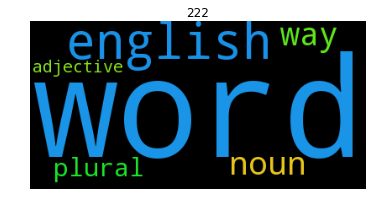

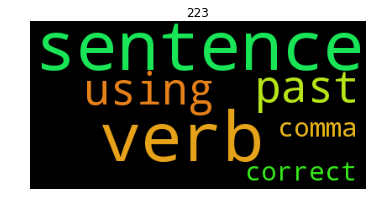

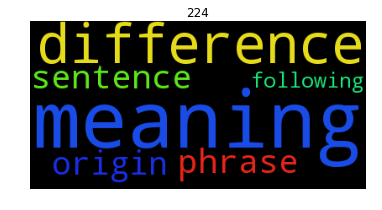

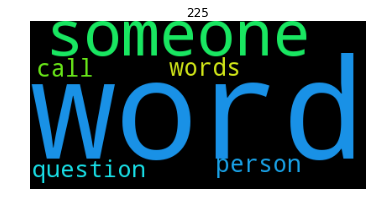

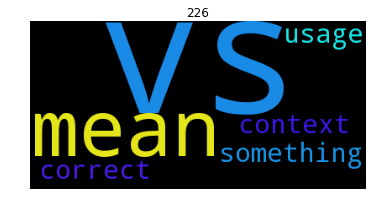

In [18]:
from wordcloud import WordCloud
curr_topic = 222

for line in ldamodel.print_topics(NUM_TOPICS, 6):
        line = line[1]
        scores = [float(x.split("*")[0]) for x in line.split(" + ")]
        words = [x.split("*")[1] for x in line.split(" + ")]
        freqs = []
        for word, score in zip(words, scores):
            freqs.append((word, score))
        wc = WordCloud().fit_words(freqs)

        plt.figure()
        #plt.subplot(curr_topic)
        plt.imshow(wc)
        plt.axis("off")
        plt.title(curr_topic)
        plt.grid(True)
        #wordcloud.draw(elements, "gs_topic_%d.png" % (curr_topic), width=120, height=120)
        curr_topic += 1
plt.show()

# Approach 2 : Doc2Vec
===================================

In [113]:
class LabeledLineSentence(object):
    def __init__(self,df,field,tag):
        self.df = df
        self.field = field
        self.tag = tag

    def __iter__(self):
        for index, row in self.df.iterrows():
            tokens = stop_words.remove(row[self.field])
            yield doc2vec.TaggedDocument(words=tokens,tags=[row[self.tag]])

In [114]:
def get_doc2vec(force=False):
    doc2vecFile = 'doc2vec.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(doc2vecFile) and not force):
        # load trained model from file
        docmodel = Doc2Vec.load(doc2vecFile)
    else:
        lablines = LabeledLineSentence(posts,'Title','Id')
        
        # Create model
        docmodel = doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
        docmodel.build_vocab(lablines)

        for epoch in range(10):
            docmodel.train(lablines)
            docmodel.alpha -= 0.002  # decrease the learning rate
            docmodel.min_alpha = docmodel.alpha  # fix the learning rate, no decay

        # Save model
        docmodel.save(doc2vecFile)
        
    return docmodel

In [115]:
docmodel = get_doc2vec()

In [116]:
class MatchingPost(object):
    matchingPercentage = 0
    title = ""
    
    def __init__(self, matchingPercentage, title):
        self.matchingPercentage = matchingPercentage
        self.title = title        

## Doc2Vec: Sample Search

In [117]:
def showsimilar(question):
    if (type(question) is not 'str'):
        question = str(question)
        
    norm_input = stop_words.remove(question) # question.split()
    q_vector = docmodel.infer_vector(norm_input)
    similar_vecs = docmodel.docvecs.most_similar(positive=[q_vector])
    similarTitles = []
    
    for vec in similar_vecs:
        post = posts[posts['Id']==vec[0]]
        if(len(post) == 0): continue
        title = posts[posts['Id']==vec[0]]['Title']
        similarPostInfo = MatchingPost(vec[1], title.iloc[0])
        similarTitles.append(similarPostInfo)
    
    print("Search results for [{}]:".format(question))
    
    # Show top 10 matches only
    for title in similarTitles:
        post = title.title
        matchPercentage = title.matchingPercentage
        print("{:10.2f}% : {}".format(matchPercentage * 100, post))

    return similarTitles

In [118]:
# Find similar questions
similarTitles = showsimilar(samples[0])

Search results for [Where does the quint in quintessential come from?]:
     93.13% : why is it  how come  and not  why come  
     88.64% : where does  santa  in santa claus come from 
     88.64% : does responsibility come with consequences 
     88.60% : where did the  juices  in  creative juices  come from 
     88.59% : where did  cc  and  bcc  come from 
     88.56% : where did  elbow grease  come from 
     88.50% : where does  can t be arsed  come from 
     88.42% : where does the  quint  in  quintessential  come from 
     88.36% :  tit for tat    where does this come from 
     88.31% : where does  cooling your heels  come from 


In [119]:
from IPython.display import display
from ipywidgets import widgets 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def handler(sender):
    showsimilar(text.value)
    
text = widgets.Text()    
display(text)    
text.on_submit(handler)


# Experimental : Try T-SNE 
=======================================

In [12]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
data = []
for index, post in posts.iterrows():
    data.append(post['Title']) 
tfidf_matrix =  tf.fit_transform(data)
feature_names = tf.get_feature_names() 
#dense = tfidf_matrix.todense()
#len(feature_names)
#feature_names[50:70]

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_matrix)
X_tsne = TSNE(learning_rate=10,n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 12769
[t-SNE] Computed conditional probabilities for sample 2000 / 12769
[t-SNE] Computed conditional probabilities for sample 3000 / 12769
[t-SNE] Computed conditional probabilities for sample 4000 / 12769
[t-SNE] Computed conditional probabilities for sample 5000 / 12769
[t-SNE] Computed conditional probabilities for sample 6000 / 12769
[t-SNE] Computed conditional probabilities for sample 7000 / 12769
[t-SNE] Computed conditional probabilities for sample 8000 / 12769
[t-SNE] Computed conditional probabilities for sample 9000 / 12769
[t-SNE] Computed conditional probabilities for sample 10000 / 12769
[t-SNE] Computed conditional probabilities for sample 11000 / 12769
[t-SNE] Computed conditional probabilities for sample 12000 / 12769
[t-SNE] Computed conditional probabilities for sample 12769 / 12769
[t-SNE] Mean sigma: 0.000000
[t-SNE] Itera

In [ ]:
'''
X_pca = PCA().fit_transform(dense)
from matplotlib.pyplot import figure

figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('T-SNE')
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA')
'''

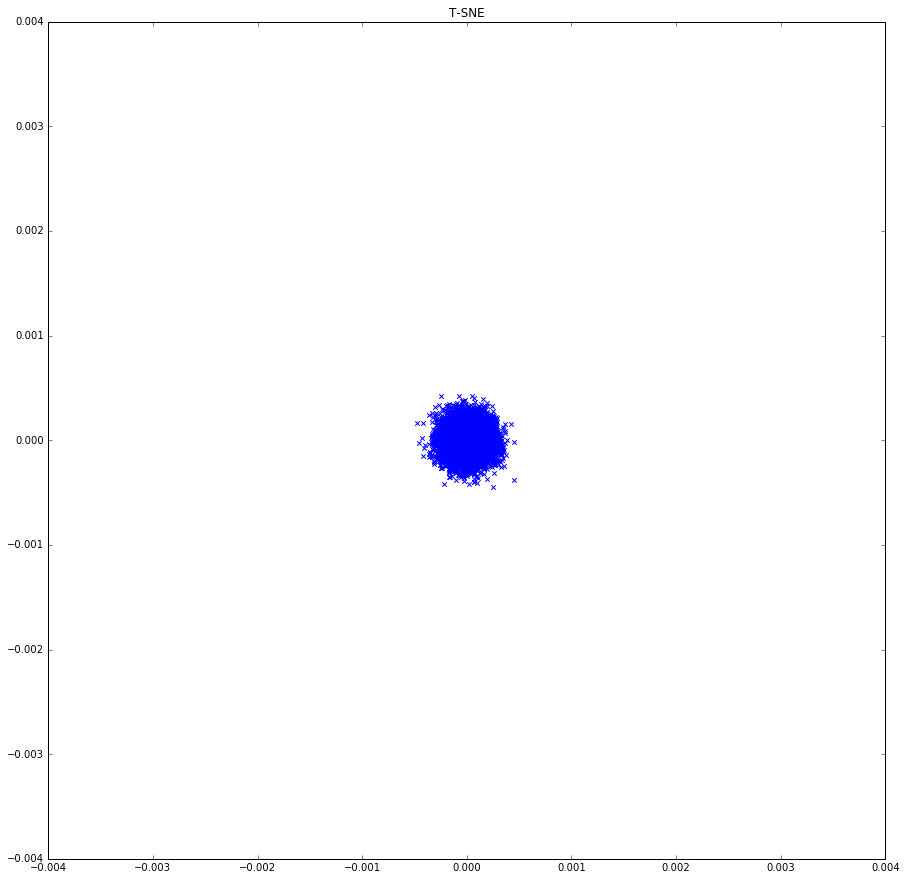

In [20]:
fig = figure(figsize=(15, 15))
#plt.setp(ax, xticks=(), yticks=())
#plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,wspace=0.0, hspace=0.0)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],marker="x")
plt.title('T-SNE')

# Future Directions

These are the kinds of questions we would like to pursue in the future:

* Predict the next question a user may ask based on this current search

* The raw data has user-generated tags for all the questions asked. Use supervised learning algorithms against this data set.

* Build a browser plugin for the use case discussed in the introduction

We are always live @ https://github.com/dhruvaray/soml


## References

* https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
* LDA Viz - http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
* This dashboard @ https://github.com/dhruvaray/soml
    